# Load Data

In [1]:
from pathlib import Path

while Path.cwd().name != 'language-model-toxicity':
    %cd ..

%matplotlib inline  

/Users/suching/Github/language-model-toxicity


In [2]:
import pandas as pd
import seaborn as sns
sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu") 
from tqdm.notebook import trange, tqdm
from spacy.tokenizer import Tokenizer
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas("progress")
from nltk.stem.porter import *
import spacy

In [3]:
def read_data(dir_):
    total = len([x for x in Path().iterdir()])
    rows = [[str(file), file.read_text()] for file in tqdm(Path("data/subsample_100k/corpus").iterdir(), total=total)]
    return pd.DataFrame(rows, columns=['filename', 'text'])

In [4]:
files = pd.read_json("data/subsample_100k_ner_tokenized.jsonl", lines=True)

In [5]:
df = pd.read_csv("data/subsample_100k/docs.csv")

In [6]:
files['filename'] = files['filename'].str.split('/').apply(lambda x: x[-1])

In [7]:
master = df.merge(files)

In [8]:
master['avg_toxicity_minus_toxicity'] = master.insult + master.severe_toxicity  + master.profanity + master.sexually_explicit + master.flirtation + master.identity_attack + master.threat
master['avg_toxicity_minus_toxicity'] = master['avg_toxicity_minus_toxicity'] / 7
master['tokenized_text'] = master['text'].str.split()

In [9]:
master.columns = ['filename', 'Insult Score', 'Severe Toxicity Score', 'Toxicity Score', 'Profanity Score', 'Sexually Explicit Score', 'Flirtation Score', 'Identity Attack Score', 'Threat Score', 'entities_NORP', 'entities_PERSON', 'text', 'Average Toxicity Score', 'tokenized_text']

### Load URLs

In [331]:
urls = pd.read_csv("data/openwebtext-urls.csv")
site_bias = pd.read_csv("data/mbfc.csv")
site_bias.columns=['source_url', 'domain', 'url', 'fact', 'bias']
urls = urls.merge(site_bias, on='domain',how='left')

# Analysis

## Toxicity Distributions

In [304]:
def plot_distributions(df, ax=None, compare_df=None, compare_df_1=None, kde=False, hist=False, logy=False, label=None, legend=None, legend_outside=False, color=None, save=None):
    if label:
        if not ax:
            f = plt.figure(figsize=(7,3))
        placement = [[label]]
    else:
        if not ax:
            f, axes = plt.subplots(4, 2, figsize=(10, 10))

        placement = [["Insult Score", "Severe Toxicity Score"],
                     ["Toxicity Score", "Profanity Score"],
                     ["Sexually Explicit Score", "Flirtation Score"],
                     ["Identity Attack Score", "Threat Score"]]
    for ix, row in enumerate(placement):
        for jx, col in enumerate(row):
            if label:
                leg = legend[0] if legend else None
                c = color[0] if color else None
                ax = sns.distplot(df[col], kde=kde, hist=hist, bins=50, label=leg, color=c, ax=ax,kde_kws={"lw": 2})
            else:
                ax = axes[ix, jx]
                sns.distplot(df[col], kde=kde, hist=hist, bins=50, ax=ax, kde_kws={"lw": 2})

            if compare_df is not None:
                if label:
                    leg = legend[1] if legend else None
                    c = color[1] if color else "blue"
                    ax = sns.distplot(compare_df[col], kde=kde, hist=hist, bins=50, color=c, label=leg, ax=ax, kde_kws={"lw": 2})
                else:
                    ax = sns.distplot(compare_df[col], kde=kde, hist=hist, bins=50, ax=ax, color="blue", kde_kws={"lw": 2})
            
            if compare_df_1 is not None:
                if label:
                    leg = legend[2] if legend else None
                    c = color[2] if color else "blue"
                    ax = sns.distplot(compare_df_1[col], kde=kde, hist=hist, bins=50, color=c, label=leg, ax=ax, kde_kws={"lw": 2})
                else:
                    ax = sns.distplot(compare_df_1[col], kde=kde, hist=hist, bins=50, ax=ax, color="blue", kde_kws={"lw": 2})
            if (ix, jx) == (0, 0):
                if not kde:
                    ax.set_ylabel("# Documents")
                else:
                    ax.set_ylabel("Density")
            ax.set_xlim([0, 1])
            if logy:
                ax.set_yscale('log')
            if legend:
                if legend_outside:
                    plt.legend(bbox_to_anchor=(-1.05, 1), loc=2, borderaxespad=0.)
                else:
                    plt.legend()


                
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300)
    return ax

In [259]:
def extract_entity(doc, label):
    norps = []
    for ent in doc.ents:
        if ent.label_ == label: 
            norps.append(ent.text)
    return norps

def get_popular_entities(df, entity, entity_label, pal=None, remove=[], convert={}, ax=None):
    stemmer = PorterStemmer()
    entities = [stemmer.stem(st.lower()) for row in tqdm(df[entity]) for st in row]
    entities = [x for x in entities if x not in remove]
    if convert:
        entities = [convert[x] if convert.get(x) else x for x in entities]
    data = pd.Series(entities).value_counts().head(n=10).reset_index()
    data.columns = ['Ethnic/Religious Group', '# Identity Attack Docs']
    data = data.sort_values(by='# Identity Attack Docs', ascending=True)
    ax = sns.barplot(data=data, x='# Identity Attack Docs', y='Ethnic/Religious Group', palette=pal, ax=ax)
    ax.set_xlabel("# of Mentions in Identity Attacks or Threats")
    plt.tight_layout()

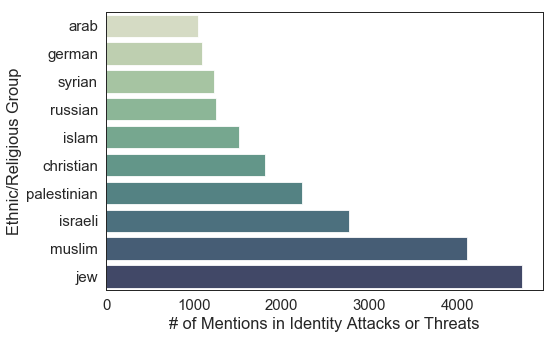

In [260]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
f = plt.figure(figsize=(8, 5))

sns.set(context="paper", style="white", font_scale=1.7) 

subdf = master.loc[(master['Identity Attack Score'] > 0.5) | (master['Threat Score'] > 0.5)]
get_popular_entities(subdf,
                     "entities_NORP",
                     "Ethnic / Religious Group",
                     pal = sns.cubehelix_palette(12, start=.5, rot=-.75, reverse=False),
                     remove=["american", "republican", "democrat"],
                     convert={"jewish": "jew", "isra": "israeli", "palestinian": "palestinian", "christian": "christian"})

# ax2 = plt.subplot(gs[:3, 3:])
# plot_distributions(master.loc[master['tokenized_text'].apply(lambda x: 'jew' in x)],
#                    compare_df=master.loc[master['tokenized_text'].apply(lambda x: 'christian' in x)],
#                    kde=True,
#                    label="Identity Attack Score",
#                    ax=ax2,
#                    color=["r", "b"],
#                    legend=["jew", "christian"],
#                    logy=False)
# ax3 = plt.subplot(gs[3:, :])
# plot_distributions(master.loc[master['tokenized_text'].apply(lambda x: 'muslim' in x)],
#                    compare_df=master.loc[master['tokenized_text'].apply(lambda x: 'christian' in x)],
#                    compare_df_1=master.loc[master['tokenized_text'].apply(lambda x: 'jew' in x)],
#                    kde=True,
#                    ax=ax3,
#                    label="Identity Attack Score",
#                    color=["r", "b", "g"],
#                    legend=["Muslim", "Christian", "Jew"],
#                    logy=False)
# plt.tight_layout()
plt.savefig("ethnic_religious_groups.pdf", dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


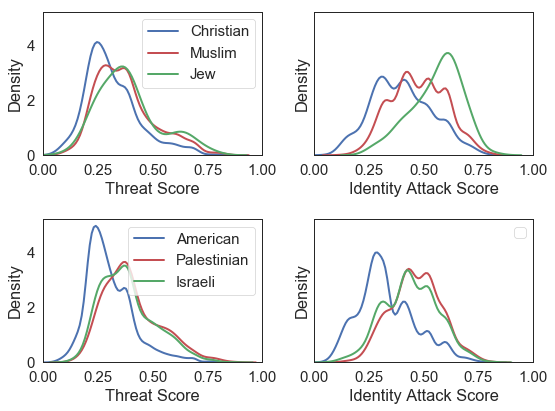

In [328]:

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

sns.set(context="paper", style="white", font_scale=1.7) 
f, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=True)

plot_distributions(master.loc[master['entities_NORP'].apply(lambda x: 'Christian' in x)],
                   compare_df=master.loc[master['entities_NORP'].apply(lambda x: 'Muslim' in x)],
                   compare_df_1=master.loc[master['entities_NORP'].apply(lambda x: 'Jew' in x)],
                   kde=True,
                   ax=axes[0,1],
                   label="Identity Attack Score",
                   color=["b", "r", "g"],
                   legend_outside=False,
                   logy=False)
plot_distributions(master.loc[master['entities_NORP'].apply(lambda x: 'Christian' in x)],
                   compare_df=master.loc[master['entities_NORP'].apply(lambda x: 'Muslim' in x)],
                   compare_df_1=master.loc[master['entities_NORP'].apply(lambda x: 'Jew' in x)],
                   kde=True,
                   ax=axes[0,0],
                   label="Threat Score",
                   color=["b", "r", "g"],
                   legend=["Christian", "Muslim", "Jew"],
                   legend_outside=False,
                   logy=False)


plot_distributions(master.loc[master['entities_NORP'].apply(lambda x: 'American' in x)],
                   compare_df=master.loc[master['entities_NORP'].apply(lambda x: 'Palestinian' in x)],
                   compare_df_1=master.loc[master['entities_NORP'].apply(lambda x: 'Israeli' in x)],
                   kde=True,
                   ax=axes[1,1],
                   label="Identity Attack Score",
                   color=["b", "r", "g"],
                   legend_outside=False,
                   logy=False)

plot_distributions(master.loc[master['entities_NORP'].apply(lambda x: 'American' in x)],
                   compare_df=master.loc[master['entities_NORP'].apply(lambda x: 'Palestinian' in x)],
                   compare_df_1=master.loc[master['entities_NORP'].apply(lambda x: 'Israeli' in x)],
                   kde=True,
                   ax=axes[1,0],
                   label="Threat Score",
                   color=["b", "r", "g"],
                   legend=["American", "Palestinian", "Israeli"],
                   legend_outside=False,
                   logy=False)


plt.tight_layout()
plt.savefig("identity_attack_dists.pdf", dpi=300)

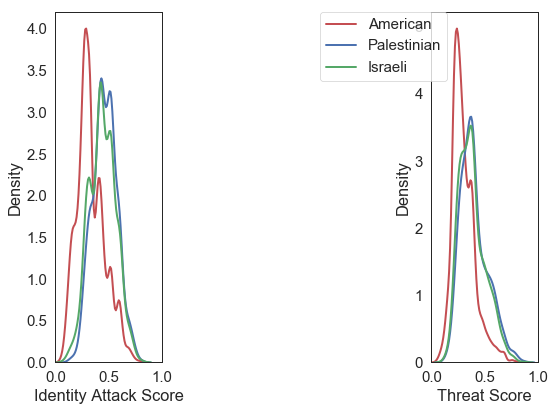

In [324]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
f = plt.figure(figsize=(8, 6))

sns.set(context="paper", style="white", font_scale=1.7) 
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[:, :1])
plot_distributions(master.loc[master['entities_NORP'].apply(lambda x: 'American' in x)],
                   compare_df=master.loc[master['entities_NORP'].apply(lambda x: 'Palestinian' in x)],
                   compare_df_1=master.loc[master['entities_NORP'].apply(lambda x: 'Israeli' in x)],
                   kde=True,
                   ax=ax1,
                   label="Identity Attack Score",
                   color=["r", "b", "g"],
                   legend=None,
                   logy=False)
ax2 = plt.subplot(gs[:, 1:])

plot_distributions(master.loc[master['entities_NORP'].apply(lambda x: 'American' in x)],
                   compare_df=master.loc[master['entities_NORP'].apply(lambda x: 'Palestinian' in x)],
                   compare_df_1=master.loc[master['entities_NORP'].apply(lambda x: 'Israeli' in x)],
                   kde=True,
                   ax=ax2,
                   label="Threat Score",
                   color=["r", "b", "g"],
                   legend=["American", "Palestinian", "Israeli"],
                   legend_outside=True,
                   logy=False)


In [224]:
site_bias

NameError: name 'site_bias' is not defined

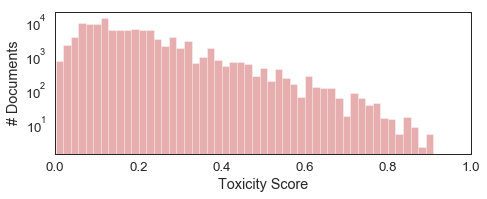

In [61]:
ax = plot_distributions(master, label='Toxicity Score', logy=True, save="toxicity_distribution.pdf")

(0, 1)

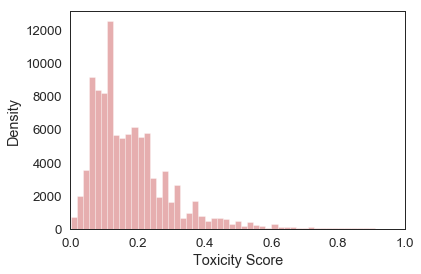

In [18]:
ax = sns.distplot(master["Toxicity Score"], kde=False, bins=50)
ax.set_ylabel("Density")
ax.set_xlim([0, 1])

(0, 1)

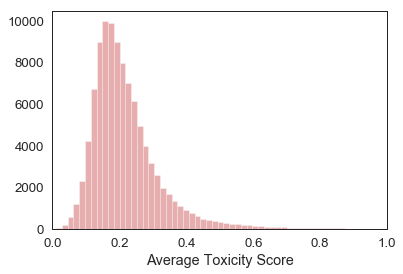

In [19]:
ax = sns.distplot(master['Average Toxicity Score'], kde=False, bins=50)
ax.set_xlim([0, 1])

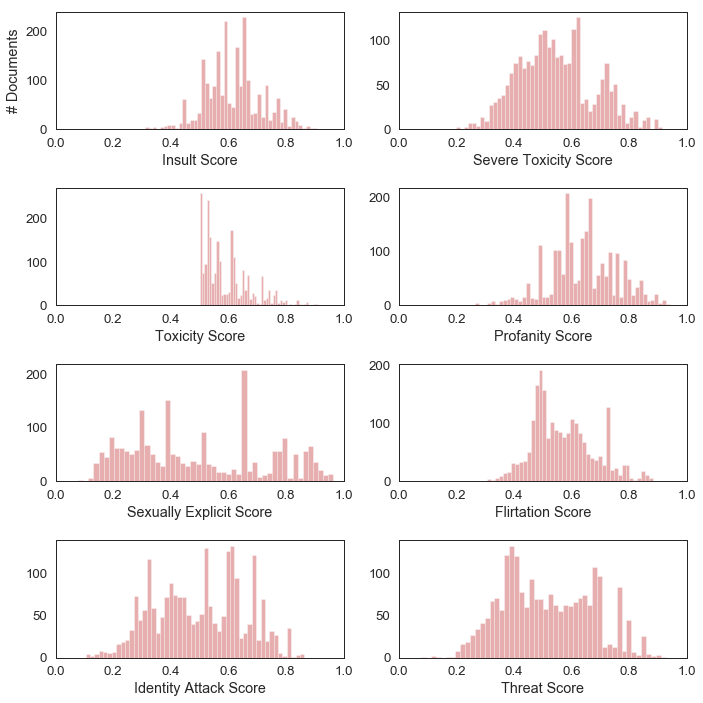

In [20]:
plot_distributions(master.loc[(master['Toxicity Score'] > 0.5)])

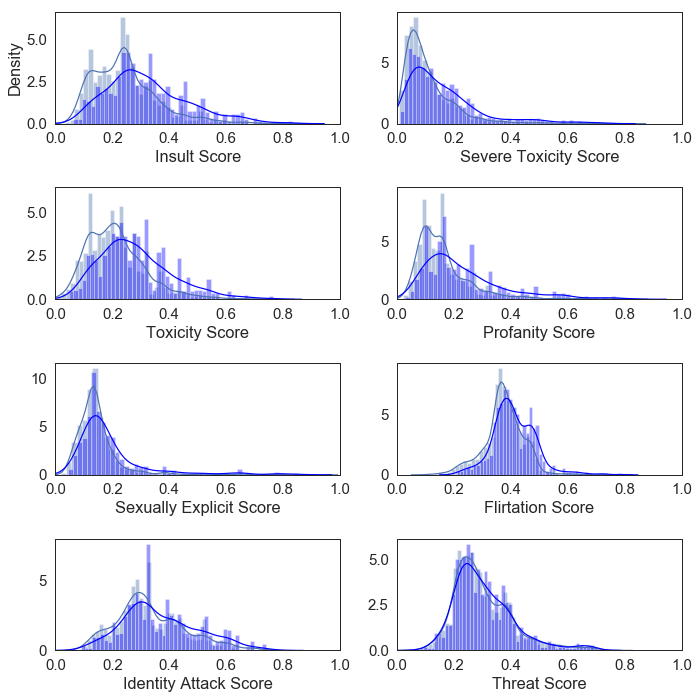

In [164]:
plot_distributions(master.loc[master['entities_PERSON'].apply(lambda x: 'Obama' in x)],
                   compare_df=master.loc[master['entities_PERSON'].apply(lambda x: 'Hillary' in x)],
                   kde=True,
                   logy=False)

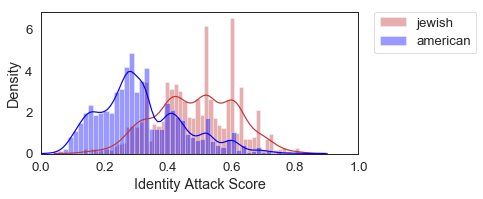

In [49]:
plot_distributions(master.loc[master['tokenized_text'].apply(lambda x: 'jewish' in x)],
                   compare_df=master.loc[master['tokenized_text'].apply(lambda x: 'american' in x)],
                   kde=True,
                   label="Identity Attack Score",
                   legend=["jewish", "american"],
                   logy=False,
                   save="jewish_american.pdf")

In [10]:
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df


slist = [(ix, st) for ix, row in tqdm(enumerate(master.tokenized_text)) for st in row]


68408074

In [ ]:
out = []
for ix, row in tqdm(enumerate(slist)):
    q = [0, 0]
    q[0] = master['Threat Score'][ix] > 0.5
    q[1] = row[1]
    out.append(q)

Exception ignored in: <function tqdm.__del__ at 0x12140bb70>
Traceback (most recent call last):
  File "/Users/suching/.pyenv/versions/miniconda3-4.3.11/envs/allennlp/lib/python3.7/site-packages/tqdm/std.py", line 1065, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

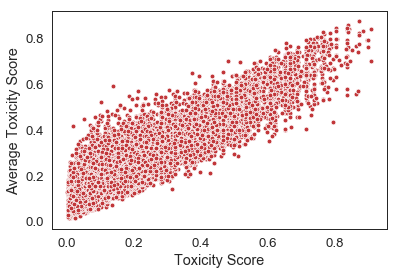

In [12]:
sns.scatterplot(data=master, x="Toxicity Score", y="Average Toxicity Score")

In [67]:
columns = [x for x in master.columns if "Score" in x]
master[columns].corr().mean()

Insult Score               0.811864
Severe Toxicity Score      0.827943
Toxicity Score             0.800019
Profanity Score            0.802461
Sexually Explicit Score    0.669512
Flirtation Score           0.606825
Identity Attack Score      0.663845
Threat Score               0.657178
Average Toxicity Score     0.861554
dtype: float64

## Naughty Words

In [22]:
with open('data/naughty_words.txt', 'r') as f:
    naughty_words = [x.strip() for x in f.readlines()]
    
def get_naughty_words(text):
    if len(set(text.split()) & set(naughty_words)) > 0:
        return set(text.split()) & set(naughty_words)
    else:
        return np.nan

master['naughty_words'] = master.text.progress_apply(get_naughty_words)
master['is_toxic_naughty_words'] = ~master.naughty_words.isna()

### Most common naughty words

In [23]:
pd.Series([item for row in master['naughty_words'].dropna() for item in row]).value_counts().head(n=15)

sex         2582
rape        1031
shit         781
fucking      620
dick         606
fuck         518
ass          490
hardcore     406
sexy         341
suck         318
porn         316
butt         290
nude         234
raping       220
bullshit     204
dtype: int64

### Naughty word false positives

In [24]:
fp = master.loc[(master['is_toxic_naughty_words'] == 1) & (master['Toxicity Score'] < 0.5)]
pd.Series([item for row in fp['naughty_words'] for item in row]).value_counts().head(n=15)

sex           2249
rape           874
dick           529
shit           406
hardcore       384
ass            295
sexy           294
porn           245
suck           244
butt           243
fucking        238
nude           202
escort         192
domination     188
raping         184
dtype: int64

### Naughty words vs. Perspective API

In [25]:
from sklearn.metrics import precision_recall_fscore_support
score_cols = [col for col in master.columns if "Score" in col]
precs = []
recalls = []
f1s = []
for col in score_cols:
    precision, recall, f1, _ = precision_recall_fscore_support(y_pred=master['is_toxic_naughty_words'],
                                                              y_true=master[col] > 0.5,
                                                              average='binary')
    print(f"{col.upper()}: precision: {precision}, recall: {recall}, f1: {f1}")
    precs.append(precision)
    recalls.append(recall)
    f1s.append(f1)

INSULT SCORE: precision: 0.20182291666666666, recall: 0.5535714285714286, f1: 0.2958015267175573
SEVERE TOXICITY SCORE: precision: 0.11675347222222222, recall: 0.766928011404134, f1: 0.2026556172897636
TOXICITY SCORE: precision: 0.1591796875, recall: 0.6626016260162602, f1: 0.2566929133858268
PROFANITY SCORE: precision: 0.19173177083333334, recall: 0.690504103165299, f1: 0.30012738853503185
SEXUALLY EXPLICIT SCORE: precision: 0.2684461805555556, recall: 0.7844007609384908, f1: 0.39999999999999997
FLIRTATION SCORE: precision: 0.2965494791666667, recall: 0.34230961923847697, f1: 0.31779069767441864
IDENTITY ATTACK SCORE: precision: 0.1929253472222222, recall: 0.3185808994803799, f1: 0.24031898357775222
THREAT SCORE: precision: 0.1557074652777778, recall: 0.26200474712433813, f1: 0.19533111005240592
AVERAGE TOXICITY SCORE: precision: 0.15201822916666666, recall: 0.7428419936373277, f1: 0.25238695730499006


## Targeted Groups

In [31]:
def get_popular_tokens(df, remove=[], convert={}):
    stemmer = PorterStemmer()
    entities = [stemmer.stem(st.lower()) for row in tqdm(df['tokenized_text']) for st in row]
    entities = [x for x in entities if x not in remove]
    if convert:
        entities = [convert[x] if convert.get(x) else x for x in entities]
    ax = pd.Series(entities).value_counts().head(n=10).plot(kind='barh')
    ax.set_ylabel("tokens")
    ax.set_xlabel("# Toxic Documents")
    plt.tight_layout()
    return entities

In [27]:
def extract_pos(doc, label):
    norps = []
    for token in doc:
        if token.tag_ == label: 
            norps.append(token.text)
    return norps

def get_popular_pos(df, pos):
    df[pos] = df.nlp_docs.progress_apply(lambda x: extract_pos(x, pos))
    stemmer = PorterStemmer()
    pos_ = [stemmer.stem(st.lower()) for row in tqdm(df[pos]) for st in row]
    ax = pd.Series(pos_).value_counts().head(n=15).plot(kind='barh')
    ax.set_ylabel(pos)
    ax.set_xlabel("Number of Docs")

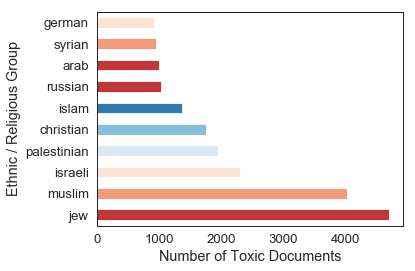

In [54]:
subdf = master.loc[(master['Identity Attack Score'] > 0.5)]
get_popular_entities(subdf,
                     "entities_NORP",
                     "Ethnic / Religious Group",
                     remove=["american", "republican", "democrat"],
                     convert={"jewish": "jew", "isra": "israeli"})
plt.savefig("ethnic_religious_groups.pdf", dpi=300)

In [21]:
pd.Series(pop_tokens).value_counts().head(n=50).tail(n=10)

offic      3989
against    3953
man        3925
how        3887
me         3873
take       3809
—          3794
year       3771
could      3762
where      3727
dtype: int64

## URL Domains Analysis

### Most popular domains

Text(0.5,0,'Percent of corpus')

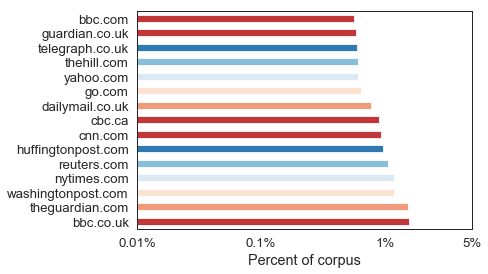

In [29]:
ax = (urls.domain.value_counts(normalize=True) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 5])
ax.set_xticklabels(["0.01%", "0.1%", "1%", "5%"])
ax.set_xlabel("Percent of corpus")

### Biased News Analysis

Text(0.5,0,'Percent of corpus')

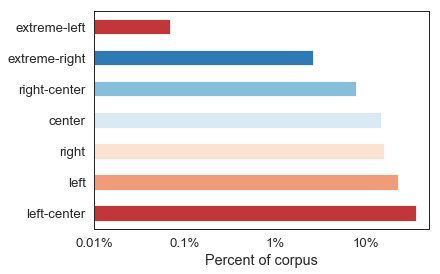

In [30]:
ax = (urls.bias.value_counts(normalize=True) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 10])
ax.set_xticklabels(["0.01%", "0.1%", "1%", "10%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

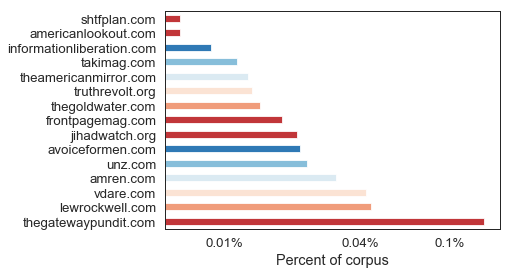

In [31]:
subdf = urls.loc[urls['bias'] == 'extreme-right']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.04, 0.1])
ax.set_xticklabels(["0.01%", "0.04%", "0.1%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

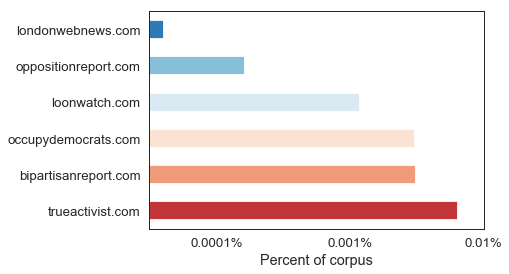

In [32]:
subdf = urls.loc[urls['bias'] == 'extreme-left']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

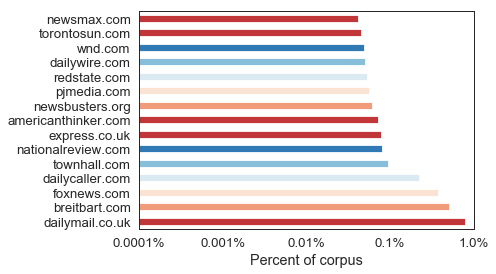

In [33]:
subdf = urls.loc[urls['bias'] == 'right']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%", "0.1%", "1.0%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

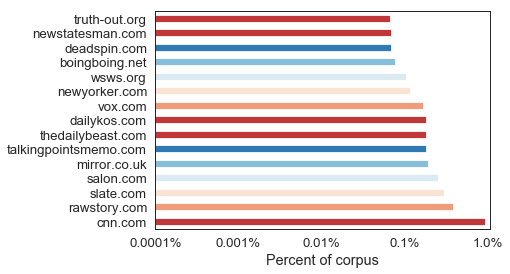

In [34]:
subdf = urls.loc[urls['bias'] == 'left']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%", "0.1%", "1.0%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

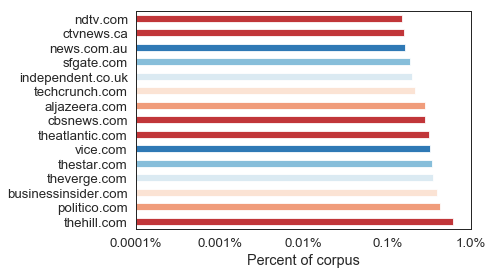

In [35]:
subdf = urls.loc[urls['bias'] == 'left-center']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%", "0.1%", "1.0%"])
ax.set_xlabel("Percent of corpus")

In [229]:
url_pop = urls.domain.value_counts()
url_pop = url_pop.reset_index()
url_pop.columns = ['domain', '# of Documents']

In [230]:
url_pop = url_pop.merge(urls[['domain', 'bias', 'fact']], on='domain').drop_duplicates(subset=['domain'])

In [231]:
url_pop = url_pop.reset_index()

In [232]:
subsample_preds = pd.read_json("data/subsample.preds.k.5", lines=True)

In [233]:
subsample_preds.columns

Index(['URL', '__label__least_prob', '__label__left-center_prob',
       '__label__left_prob', '__label__right-center_prob',
       '__label__right_prob', 'bias', 'bias_label', 'domain', 'entities_NORP',
       'entities_PERSON', 'fact', 'filename', 'source_url',
       'source_url_processed', 'text', 'url'],
      dtype='object')

In [234]:
z = subsample_preds.groupby('domain').progress_apply(lambda x: x.bias_label.value_counts()).reset_index()



In [235]:
z.columns = ['domain', 'label', 'num']

In [236]:
domains = z.loc[z.num > 1]['domain']

q = subsample_preds.loc[subsample_preds.domain.isin(domains)].groupby('domain')['__label__right_prob'].max().reset_index()

In [390]:
url_pop_master = url_pop.merge(q, on='domain')

In [391]:
url_pop_master['Factual Reliability'] = url_pop_master['fact']

In [392]:
def bucket(x):
    if x == 'extreme-left':
        return 1
    if x == 'left':
        return 2
    if x == 'left-center':
        return 3
    if x == 'center':
        return 4
    if x == 'right-center':
        return 5
    if x == 'right':
        return 6
    if x == 'extreme-right':
        return 7
    if x == 'LOW':
        return 1
    if x == "MIXED":
        return 2
    if x == "HIGH":
        return 3

In [393]:
url_pop_master['Political Bias'] = url_pop_master.bias.apply(bucket)

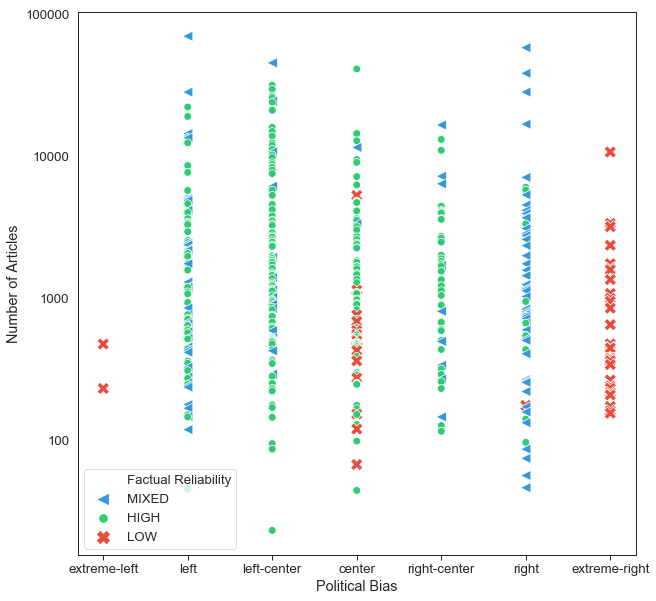

In [394]:
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=url_pop_master.dropna(), x="Political Bias",y="# of Documents", hue="Factual Reliability", style='Factual Reliability', size='Factual Reliability', size_order=['LOW', 'MIXED', 'HIGH'], markers = {"LOW": "X", "MIXED": "<", "HIGH": "o"}, style_order=['LOW', 'MIXED', 'HIGH'], sizes=(60, 150), palette = ["#3498db","#2ecc71", "#e74c3c" ])
ax.set_yscale('log')
ax.set_ylabel("Number of Articles")
ax.set_yticks([100, 1000, 10000, 100000])
ax.set_yticklabels([100, 1000, 10000, 100000])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["extreme-left", "left", "left-center", "center", "right-center", "right", "extreme-right"])
ax.xaxis.tick_bottom()


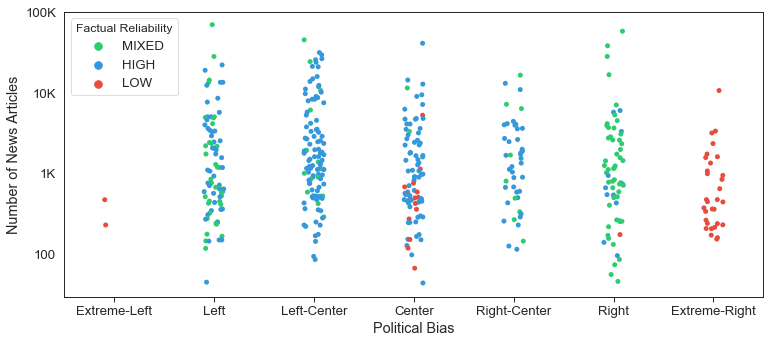

In [395]:
fig = plt.figure(figsize=(11,5))
palette = sns.color_palette(["#2ecc71","#3498db", "#e74c3c" ])

sns.set(context="paper", style="white", font_scale=1.5, palette=palette, color_codes=False) 
ax = sns.stripplot(data=url_pop_master.dropna(), x="Political Bias", size=5, y="# of Documents", hue="Factual Reliability",  jitter=0.1)
ax.set_yscale('log')
ax.set_ylabel("Number of News Articles")
ax.set_yticks([100, 1000, 10000, 100000])
ax.set_yticklabels([100, "1K", "10K", "100K"])
ax.set_xticks([0,1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["Extreme-Left", "Left", "Left-Center", "Center", "Right-Center", "Right", "Extreme-Right"])

ax.xaxis.tick_bottom()
plt.tight_layout()
plt.savefig("news_bias.pdf", dpi=300)

In [251]:
url_pop_master['Political Bias'].value_counts(normalize=True)

3.0    0.266509
4.0    0.202830
2.0    0.198113
6.0    0.148585
5.0    0.106132
7.0    0.073113
1.0    0.004717
Name: Political Bias, dtype: float64

In [252]:
26.6 + 20.2 + 19.8

66.6

In [250]:
url_pop_master.dropna().fact.value_counts().sum()

424

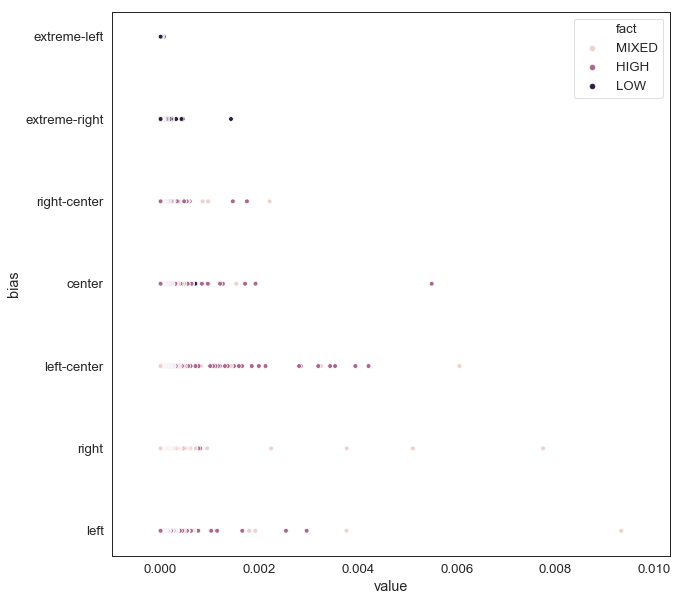

In [231]:
url_pop.dropna()
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=url_pop, x="value",y="bias", hue="fact", palette=sns.cubehelix_palette(3))
plt.savefig("test_bias.pdf", dpi=300)

### Fake News Analysis

[Text(0,0,'High'), Text(0,0,'Mixed'), Text(0,0,'Low')]

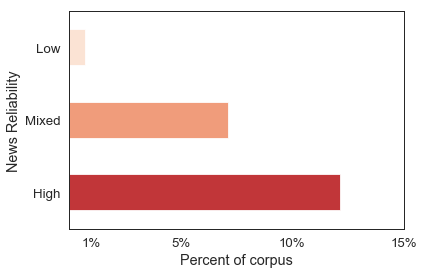

In [219]:
ax = ((urls.fact.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xticks([1, 5, 10, 15])
ax.set_xticklabels(["1%", "5%", "10%", "15%"])
ax.set_xlabel("Percent of corpus")
ax.set_ylabel("News Reliability")
ax.set_yticklabels(["Low", "Mixed", "High"][::-1])

Text(0.5,0,'Percent of corpus')

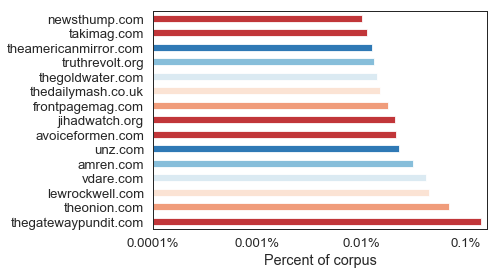

In [206]:
subdf = urls.loc[urls['fact'] == 'LOW']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%", "0.1%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

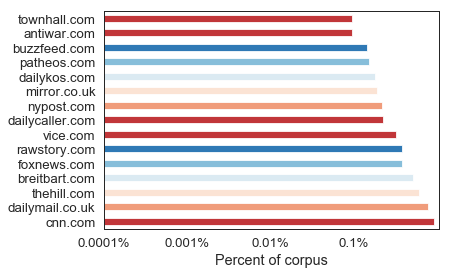

In [208]:
subdf = urls.loc[urls['fact'] == 'MIXED']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%", "0.1%"])
ax.set_xlabel("Percent of corpus")

Text(0.5,0,'Percent of corpus')

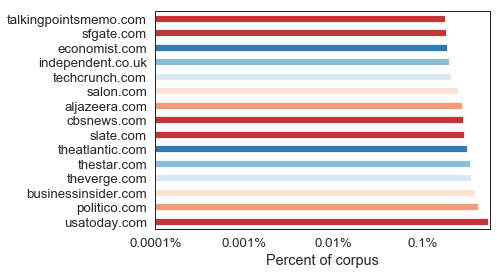

In [220]:
subdf = urls.loc[urls['fact'] == 'HIGH']
ax = ((subdf.domain.value_counts() / urls.shape[0]) * 100).head(n=15).plot(kind='barh')
ax.set_xscale('log')
ax.set_xticks([0.0001, 0.001, 0.01, 0.1])
ax.set_xticklabels(["0.0001%", "0.001%", "0.01%", "0.1%"])
ax.set_xlabel("Percent of corpus")

In [396]:
urls_master = master.merge(urls, on='filename')
urls_master['Political Bias'] = urls_master.bias.apply(bucket)
urls_master['Factual Reliability'] = urls_master.fact.apply(bucket)

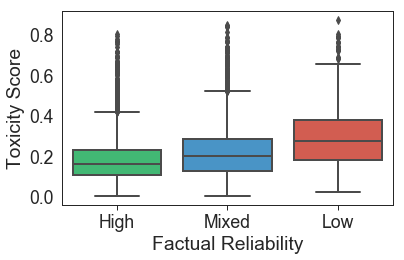

In [387]:
pal = sns.color_palette(["#2ecc71","#3498db", "#e74c3c" ])
sns.set(context="paper", style="white", font_scale=2.0, palette=pal,color_codes=False) 
ax = sns.boxplot(data=urls_master,x='fact', y='Toxicity Score', linewidth=2, palette=pal)
ax.set_xticklabels(["High", "Mixed", "Low"])
ax.set_xlabel("Factual Reliability")
ax.xaxis.tick_bottom()
plt.tight_layout()
plt.savefig("factual_reliability_toxicity.pdf", dpi=300)

In [407]:
score_cols = [x for x in urls_master.columns if "Score" in x]
urls_master[['Factual Reliability'] + score_cols].corr(method='spearman')


,Factual Reliability,Insult Score,Severe Toxicity Score,Toxicity Score,Profanity Score,Sexually Explicit Score,Flirtation Score,Identity Attack Score,Threat Score,Average Toxicity Score
Factual Reliability,1.000000,-0.208337,-0.171811,-0.196927,-0.185072,-0.109036,-0.080948,-0.190608,-0.147705,-0.189023
Insult Score,-0.208337,1.000000,0.910244,0.910282,0.948409,0.631268,0.519131,0.848223,0.679970,0.934641
Severe Toxicity Score,-0.171811,0.910244,1.000000,0.922049,0.947534,0.737359,0.669296,0.742682,0.749912,0.958354
Toxicity Score,-0.196927,0.910282,0.922049,1.000000,0.896452,0.590851,0.513145,0.729390,0.646095,0.871191
Profanity Score,-0.185072,0.948409,0.947534,0.896452,1.000000,0.736706,0.632540,0.726057,0.685737,0.945525
Sexually Explicit Score,-0.109036,0.631268,0.737359,0.590851,0.736706,1.000000,0.788468,0.473021,0.550580,0.779347
Flirtation Score,-0.080948,0.519131,0.669296,0.513145,0.632540,0.788468,1.000000,0.325076,0.501561,0.685984
Identity Attack Score,-0.190608,0.848223,0.742682,0.729390,0.726057,0.473021,0.325076,1.000000,0.668111,0.823490
Threat Score,-0.147705,0.679970,0.749912,0.646095,0.685737,0.550580,0.501561,0.668111,1.000000,0.807839
Average Toxicity Score,-0.189023,0.934641,0.958354,0.871191,0.945525,0.779347,0.685984,0.823490,0.807839,1.000000


In [414]:
np.std([-0.21, -0.17, -0.20 , -0.19, -0.11, -0.08, -0.19, -0.15])

0.043229041164476456

In [410]:
urls_master[['Political Bias'] + score_cols].dropna().corr(method='spearman')

,Political Bias,Insult Score,Severe Toxicity Score,Toxicity Score,Profanity Score,Sexually Explicit Score,Flirtation Score,Identity Attack Score,Threat Score,Average Toxicity Score
Political Bias,1.000000,0.015734,0.026733,0.015630,0.009292,0.020898,0.035526,0.030677,0.056164,0.032200
Insult Score,0.015734,1.000000,0.910193,0.897543,0.951546,0.605325,0.545202,0.836687,0.630564,0.930757
Severe Toxicity Score,0.026733,0.910193,1.000000,0.912115,0.942602,0.706394,0.672484,0.761598,0.746520,0.964521
Toxicity Score,0.015630,0.897543,0.912115,1.000000,0.886029,0.550595,0.537449,0.714018,0.618907,0.861319
Profanity Score,0.009292,0.951546,0.942602,0.886029,1.000000,0.711264,0.638245,0.724940,0.656064,0.943524
Sexually Explicit Score,0.020898,0.605325,0.706394,0.550595,0.711264,1.000000,0.773942,0.440947,0.512754,0.751592
Flirtation Score,0.035526,0.545202,0.672484,0.537449,0.638245,0.773942,1.000000,0.338131,0.509640,0.694375
Identity Attack Score,0.030677,0.836687,0.761598,0.714018,0.724940,0.440947,0.338131,1.000000,0.635519,0.823923
Threat Score,0.056164,0.630564,0.746520,0.618907,0.656064,0.512754,0.509640,0.635519,1.000000,0.787793
Average Toxicity Score,0.032200,0.930757,0.964521,0.861319,0.943524,0.751592,0.694375,0.823923,0.787793,1.000000


In [412]:
np.mean([0.02, 0.03, 0.02 , 0.01, 0.02, 0.04, 0.03, 0.06])

0.014523687548277812

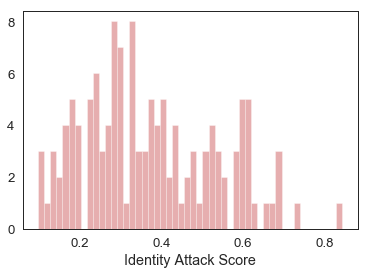

In [79]:
sns.distplot(urls_master.loc[urls_master.domain == 'thegatewaypundit.com']['Identity Attack Score'], kde=False, bins=50)

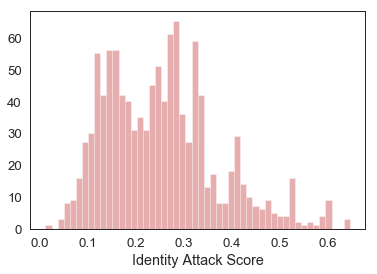

In [81]:
sns.distplot(urls_master.loc[urls_master.domain == 'nytimes.com']['Identity Attack Score'], kde=False, bins=50)

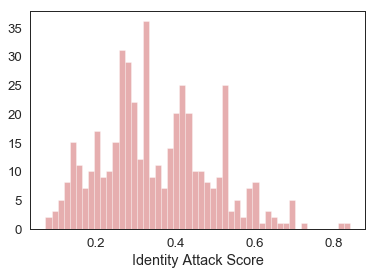

In [82]:
sns.distplot(urls_master.loc[urls_master.domain == 'breitbart.com']['Identity Attack Score'], kde=False, bins=50)